In [454]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch,VerticalPitch,FontManager
import seaborn as sns
import os
import requests
from bs4 import BeautifulSoup
import json
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from matplotlib import gridspec
from highlight_text import ax_text,fig_text
import matplotlib
import matplotlib.ticker as ticker


In [455]:
match_id=input('enter_id: ')

enter_id: 4205640


In [456]:
#data of coordinate data

In [492]:
url1=input("enter the url: ")


enter the url: https://1xbet.whoscored.com/Matches/1734809/Live/Spain-LaLiga-2023-2024-Villarreal-Atletico-Madrid


In [493]:
res1=requests.get(url1,headers={'User-Agent':"Mozilla/5.0"})

In [495]:
soup1=BeautifulSoup(res1.content,"lxml")
scripts1=soup1.find_all("script")
strings=scripts1[24].string
strings
ind_start=strings.index("matchCentreData:")+17
ind_end=strings.index(",\r\n            matchCentreEventTypeJson")
json_data=strings[ind_start:ind_end]
data=json.loads(json_data)
home_id=data["home"]['teamId']
away_id=data["away"]['teamId']
home_name=data['home']['name']
away_name=data['away']['name']
stadium=data['venueName']
date=data['timeStamp'].split(" ")[0]
team_name=pd.DataFrame(data={'teamId':[home_id,away_id],'team':[home_name,away_name]},index=[0,1])
event=data["events"]
player=data["playerIdNameDictionary"]
home_number=data["home"]['formations'][0]["jerseyNumbers"]
home_player_id=data["home"]['formations'][0]["playerIds"]

home_num=pd.DataFrame(home_player_id,index=home_number)

away_number=data["away"]['formations'][0]["jerseyNumbers"]
away_player_id=data["away"]['formations'][0]["playerIds"]
away_num=pd.DataFrame(away_player_id,index=away_number)
away_num.reset_index(inplace=True)

home_num.reset_index(inplace=True)
away_num.columns=["jersy_no","playerId"]
home_num.columns=["jersy_no","playerId"]
merge_jersey=pd.concat([home_num,away_num],axis=0)
merge_jersey['playerId']=merge_jersey['playerId'].apply(lambda x:float(x))
score=data['score']

In [496]:
df1=pd.DataFrame(event)
df2=pd.Series(player)
df2=pd.DataFrame(df2)
df2.reset_index(inplace=True)


df2.columns=["playerId","player_name"]
df2['playerId']=df2['playerId'].apply(lambda x:float(x))
df2=pd.merge(df2,merge_jersey,how="inner",on="playerId")





df1=df1[["id","minute","second","teamId","period","type","outcomeType","playerId","x","y","endX","endY"]]
data1=df1.merge(df2,how="left",on="playerId")

In [497]:
#data for shot map

In [498]:
# data  from fotmob

url = 'https://www.fotmob.com/api/matchDetails?matchId='+match_id
payload = {}
headers={}
response = requests.request("GET",url,headers=headers,data=payload)
data=response.json()
data2=pd.DataFrame(data['content']['shotmap']['shots'])
data2=data2[['id',"eventType",'x','y','playerName','min','expectedGoals','expectedGoalsOnTarget','shotType','situation','period','teamId']]
for x,values in data["general"].items():
    if x=="homeTeam":
        team1=pd.DataFrame(values,index=[0])
    elif x=="awayTeam":
        team2=pd.DataFrame(values,index=[1])
    else:
        pass
        
    
teams=pd.concat([team1,team2],axis=0)
home=teams['name'].unique()[0]
away=teams["name"].unique()[1]
data2=pd.merge(data2,teams,how="left",left_on='teamId',right_on='id')
data2=data2.rename(columns={"expectedGoals":"xG","expectedGoalsOnTarget":"xGOT","name":"team"})



In [499]:
data2.head()

,id_x,eventType,x,y,playerName,min,xG,xGOT,shotType,situation,period,teamId,team,id_y
0,2666420743,AttemptSaved,95.061404,24.419618,Samuel Dias Lino,7,0.297664,0.7770,RightFoot,RegularPlay,FirstHalf,9906,Atletico Madrid,9906
1,2666421835,Goal,100.163793,39.545000,Axel Witsel,9,0.085268,0.5714,Header,FromCorner,FirstHalf,9906,Atletico Madrid,9906
2,2666422621,AttemptSaved,91.900000,48.344713,Memphis Depay,11,0.040309,0.0807,RightFoot,RegularPlay,FirstHalf,9906,Atletico Madrid,9906
3,2666426725,AttemptSaved,94.675439,30.492500,Marcos Llorente,17,0.100285,0.2059,RightFoot,RegularPlay,FirstHalf,9906,Atletico Madrid,9906
4,2666428711,Miss,98.438596,38.536429,Aissa Mandi,20,0.085597,NaN,RightFoot,SetPiece,FirstHalf,10205,Villarreal,10205


In [500]:
#for cleaning coordinate data

In [501]:
#data1["period"]=data1["period"].apply(lambda x: str(x))
#data1["period"].str.split(":",n=3,expand=True)[2].str.strip("}")
def clean1(x):
    cleandata=x.apply(lambda x:str(x))
    cleandata=cleandata.str.split(":",n=3,expand=True)[2]
    cleandata=cleandata.str.replace("[^a-zA-z0-9]","",regex=True)
    return cleandata
    

data1["type"]=clean1(data1["type"])
data1["outcomeType"]=clean1(data1["outcomeType"])
data1["period"]=clean1(data1["period"])
data1["teamId"].unique()

array([ 63, 839], dtype=int64)

In [502]:

data1=pd.merge(data1,team_name,how='left',on='teamId')
data1["jersy_no1"]=data1["jersy_no"].fillna(0.0)
data1["jersy_no1"]=data1["jersy_no1"].apply(lambda x: int(x))
data1['jersy_no1'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 1631 entries, 0 to 1630
Series name: jersy_no1
Non-Null Count  Dtype
--------------  -----
1631 non-null   int64
dtypes: int64(1)
memory usage: 12.9 KB


([<matplotlib.lines.Line2D at 0x192a50fe650>],
 <matplotlib.collections.PathCollection at 0x192a4f368d0>)

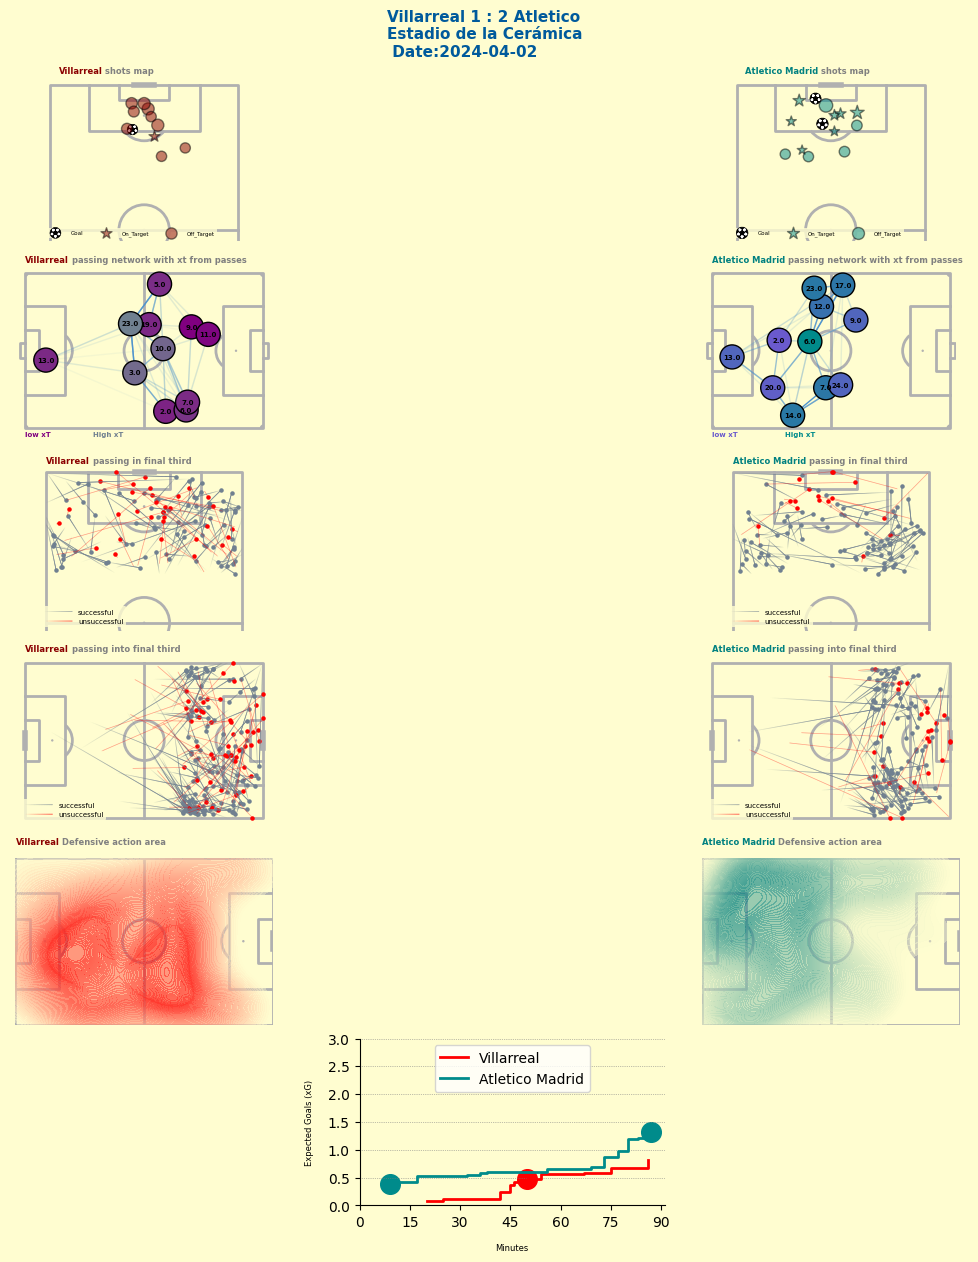

In [516]:
fig=plt.figure(figsize=(10,12),facecolor="#FFFDD0",layout='constrained')
gs=fig.add_gridspec(nrows=6,ncols=3)
fig.text(s=f'{home_name} {score} {away_name}\n{stadium}\n Date:{date}',x=.4,y=1,size=11,weight='bold',color='#005A9C')
#shot plot home
ax1=plt.subplot(gs[0])
shot_map(data2,home,ax=ax1,x="#8B0000")
ax_text(x=65, y=112,
              s=f'<{home}> <shots map>',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax1, weight = "bold",size=6)



# shot plot away
ax2=plt.subplot(gs[2])
shot_map(data2,away,ax=ax2,x="#008B8B")
ax_text(x=65, y=112,
              s=f'<{away}> <shots map>',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
              ax=ax2, weight = "bold",size=6)


#passing network home
ax3=plt.subplot(gs[3])
cmap=matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap',['#800080','#708090'])
#for low to high xt
ax_text(x=.1, y=-2,
              s=f'<low xT>                 <High xT>',
              highlight_textprops=[{"color": '#800080'},
                                   {"color": '#708090'}],
              ax=ax3, weight = "bold",size=5)
passing_network(data1,home_name,ax=ax3,x=cmap)
ax_text(x=.1, y=112,
              s=f'<{home}> <passing network with xt from passes>',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax3, weight = "bold",size=6)

#passing networek away
ax4=plt.subplot(gs[5])
cmap1=matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap',['#6A5ACD',"#008B8B"])
#for low to high xt
ax_text(x=.1, y=-2,
              s=f'<low xT>                   <High xT>',
              highlight_textprops=[{"color": '#6A5ACD'},
                                   {"color": "#008B8B"}],
              ax=ax4, weight = "bold",size=5)
passing_network(data1,away_name,ax=ax4,x=cmap1)
ax_text(x=.1, y=112,
              s=f'<{away}> <passing network with xt from passes>',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
              ax=ax4, weight = "bold",size=6)

# final third passing home
ax6=plt.subplot(gs[6])
final_third(data1,home_name,ax=ax6)
ax_text(x=100, y=105,
              s=f'<{home}> <passing in final third>',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax6, weight = "bold",size=6)

# final third passing away
ax8=plt.subplot(gs[8])
final_third(data1,away_name,ax=ax8)
ax_text(x=100, y=105,
              s=f'<{away}> <passing in final third>',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
              ax=ax8, weight = "bold",size=6)
# in to final third home
ax9=plt.subplot(gs[9])
final_into_third(data1,home_name,ax=ax9)
ax_text(x=.1, y=112,
              s=f'<{home}> <passing into final third>',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax9, weight = "bold",size=6)
# in to final third away
ax11=plt.subplot(gs[11])
final_into_third(data1,away_name,ax=ax11)
ax_text(x=.1, y=112,
              s=f'<{away}> <passing into final third>',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
           ax=ax11, weight ="bold",size=6)
# defensive action home team
ax12=plt.subplot(gs[12])
custommap1=matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap',["#FFFDD0",'red'])
defensive_action(data1,home_name,ax=ax12,x=custommap1)
ax_text(x=.1, y=112,
              s=f'<{home}> <Defensive action area>',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax12, weight = "bold",size=6)
# defensive action away
ax12=plt.subplot(gs[14])
custommap2=matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap',["#FFFDD0","#008080"])
defensive_action(data1,away_name,ax=ax12,x=custommap2)
ax_text(x=.1, y=112,
              s=f'<{away}> <Defensive action area>',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
              ax=ax12, weight = "bold",size=6)
ax13=plt.subplot(gs[16])
xg_flow(data2,home,away,ax=ax13)

ax14=plt



In [ ]:
#shot function

In [511]:
def shot_map(df,team,ax,x):
    goal=df.loc[(df["team"]==team)&(df["eventType"]=="Goal")].copy()
    on_target=df.loc[(df["team"]==team)&(df["eventType"]=="AttemptSaved")].copy()
    off_target=df.loc[(df["team"]==team)&(df["eventType"].isin(["Miss","Post"]))].copy()
    pitch=VerticalPitch(pitch_type="uefa",half=True,pitch_color="#FFFDD0")
    pitch.draw(ax=ax)
    goal=pitch.scatter(goal['x'],goal["y"],s=(goal["xG"]*200)+50,ax=ax,alpha=1,label="Goal",marker="football")
    on_target=pitch.scatter(on_target['x'],on_target["y"],s=(on_target["xG"]*200)+50,ax=ax,c=x,edgecolor="black",label="On_Target",marker="*",alpha=.5)
    off_target=pitch.scatter(off_target['x'],off_target["y"],s=(off_target["xG"]*200)+50,ax=ax,c=x,edgecolor="black",label="Off_Target",marker="o",alpha=.5)
    ax.legend(facecolor='#FFFDD0', edgecolor='None', fontsize=4,loc="lower left", handlelength=4,ncols=3)
    return goal,on_target,off_target

In [512]:
#final third passing
def final_third(df,team,ax):
    sucessful=df.loc[(df['team']==team)&(df["type"]=="Pass")&(df['x']>66)&(df['endX']>66)&(df['outcomeType']=='Successful')].copy()
    unsucesful=df.loc[(df['team']==team)&(df["type"]=="Pass")&(df['x']>66)&(df['endX']>66)&(df['outcomeType']!='Successful')].copy()
    pitch=VerticalPitch(pitch_type='opta',pitch_color="#FFFDD0",half=True)
    pitch.draw(ax=ax)
    lines1=pitch.lines(sucessful['x'],sucessful['y'],sucessful['endX'],sucessful['endY'],ax=ax,color='#708090',lw=.5,transparent=True,label="successful")
    lines2=pitch.lines(unsucesful['x'],unsucesful['y'],unsucesful['endX'],unsucesful['endY'],ax=ax,color='#FF0000',lw=.5,transparent=True,label="unsuccessful",alpha=.2)
    scatter1=pitch.scatter(sucessful['endX'],sucessful['endY'],ax=ax,color='#708090',s=5)
    scatter2=pitch.scatter(unsucesful['endX'],unsucesful['endY'],ax=ax,color='#FF0000',s=5)
    ax.legend(facecolor='#FFFDD0', edgecolor='None', fontsize=5, loc='lower left', handlelength=4)
    
    return lines1,lines2,scatter1,scatter2

In [513]:
#passing into the final third
def final_into_third(df,team,ax):
    sucessful=df.loc[(df['team']==team)&(df["type"]=="Pass")&(df['endX']>66)&(df['outcomeType']=='Successful')].copy()
    unsucesful=df.loc[(df['team']==team)&(df["type"]=="Pass")&(df['endX']>66)&(df['outcomeType']!='Successful')].copy()
    pitch=Pitch(pitch_type='opta',pitch_color="#FFFDD0")
    pitch.draw(ax=ax)
    lines1=pitch.lines(sucessful['x'],sucessful['y'],sucessful['endX'],sucessful['endY'],ax=ax,color='#708090',lw=.5,transparent=True,label="successful")
    lines2=pitch.lines(unsucesful['x'],unsucesful['y'],unsucesful['endX'],unsucesful['endY'],ax=ax,color='#FF0000',lw=.5,transparent=True,label="unsuccessful",alpha=.2)
    scatter1=pitch.scatter(sucessful['endX'],sucessful['endY'],ax=ax,color='#708090',s=5)
    scatter2=pitch.scatter(unsucesful['endX'],unsucesful['endY'],ax=ax,color='#FF0000',s=5)
    ax.legend(facecolor='#FFFDD0', edgecolor='None', fontsize=5, loc='lower left', handlelength=4)
    return lines1,lines2,scatter1,scatter2

In [514]:
#defensive function
def defensive_action(df,team,ax,x):
    
    df=df.loc[(df['type'].isin(['BallRecovery','Tackle', 'Interception','Foul','Clearance']))&(df['team']==team)].copy()
    pitch=Pitch(pitch_type='opta',pitch_color="#FFFDD0")
    pitch.draw(ax=ax)
    
    kde=sns.kdeplot(x=df['x'],y=df['y'],cmap=x,ax=ax,fill=True,levels=100,zorder=1,alpha=.4)
    plt.xlim(0,100)
    plt.ylim(0,100)
    
    return kde
    
    

In [507]:
#create  passing network
def passing_network(df,team,ax,x):
    df=df.loc[df['team']==team]
    
    df["passer"]=df["jersy_no1"]
    df["recipiant"]=df["jersy_no1"].shift(-1)
    
    sub=df.loc[(df['type']=='SubstitutionOff')]['minute'].min()
   
    
    df=df.loc[(df['type']=='Pass')&(df['outcomeType']=='Successful')&(df["minute"]<sub)]
    
    xT=pd.read_csv('xT_Grid.csv',header=None)
    xT=np.array(xT)
    cols=xT.shape[1]
    rows=xT.shape[0]
    df=df.copy()
    df.loc[:, "x_bin"] = pd.cut(df["x"], bins=cols, labels=False)
    df.loc[:, "y_bin"] = pd.cut(df["y"], bins=rows, labels=False)
    df.loc[:, "x1_bin"] = pd.cut(df["endX"], bins=cols, labels=False)
    df.loc[:, "y1_bin"] = pd.cut(df["endX"], bins=rows, labels=False)

    # Calculate start and end zone values
    df.loc[:, "start_zone_value"] = df[["x_bin","y_bin"]].apply(lambda row: xT[row[1]][row[0]], axis=1)
    df.loc[:, "end_zone_value"] = df[["x1_bin","y1_bin"]].apply(lambda row: xT[row[1]][row[0]], axis=1)
    df.loc[:, "XT"] =df["end_zone_value"] - df["start_zone_value"]

    average_loc=df.groupby("passer").agg({"x":["median"],"y":["median","count"],"XT":["sum"]})
    average_loc.columns=["x","y","pass_count","XT"]
    pass_between=df.groupby(["passer",'recipiant']).id.count().reset_index()
    pass_between.rename({"id":"pass_count"},axis="columns",inplace=True)
    pass_between=pass_between.merge(average_loc,left_on="passer",right_index=True)
    pass_between=pass_between.merge(average_loc,left_on="recipiant",right_index=True,suffixes=["","_end"])
    def normalization(x):
        
        return (x-x.min())/(x.max()-x.min())
    pass_between["normalization_pass"]=normalization(pass_between["pass_count_x"])
    average_loc["normalization_xt"]=normalization(average_loc["XT"])
#drawing a pitch
    pitch=Pitch(pitch_type="opta",corner_arcs=True,goal_type="box",pitch_color="#FFFDD0")
    pitch.draw(ax=ax)
    
    arrows=pitch.arrows(pass_between["x"],pass_between["y"],pass_between["x_end"],pass_between["y_end"],ax=ax,color="#4F94CD",width=1,zorder=1,alpha=pass_between["normalization_pass"])
    nodes=pitch.scatter(x=average_loc["x"],y=average_loc["y"],s=300,ax=ax,cmap=x,edgecolor="black",c=average_loc["normalization_xt"])
    average1_loc=average_loc.reset_index()
    average1_loc['passer']=average1_loc["passer"].apply(lambda x:int(x))
   
    for index,row in average1_loc.iterrows():
        
         annotation=pitch.annotate(row.passer,xy=(row.x,row.y),ha="center",va="center",size=5,ax=ax,weight="bold")
   
 
    return arrows,nodes
 
            
        
    
            
      
         
    


In [508]:
# create XG flow chart
def xg_flow(df,home,away,ax):
    ax.patch.set_facecolor("#FFFDD0")
    #Cumulative Sum xG home team
    h_df = df[df['team'] == home]
    h_df.sort_values(by='min', inplace=True)
    h_df['h_cum'] = h_df['xG'].cumsum()

#Cumulative Sum xG away team
    a_df = df[df['team'] == away]
    a_df.sort_values(by='min', inplace=True)
    a_df['a_cum'] = a_df['xG'].cumsum()
    h_goal = h_df[h_df['eventType'].str.contains("Goal")]
    a_goal = a_df[a_df['eventType'].str.contains("Goal")]
    a_total = round(a_df['xG'].sum(),2).astype(str)
    h_total = round(h_df['xG'].sum(),2).astype(str)
    
    
    step1=ax.step(x = h_df['min'], y = h_df['h_cum'], where = 'post', color = 'red', label= home   ,linewidth=2)  
    step2=ax.step(x = a_df['min'], y = a_df['a_cum'], where = 'post', color = '#008B8B', label= away ,linewidth=2)

# Create scatter plot for highlighting the goal
    scatter1=ax.scatter(x= h_goal['min'], y = h_goal['h_cum'] , marker= 'o', s= 200 ,color =  'red')
    scatter2=ax.scatter(x= a_goal['min'], y = a_goal['a_cum'] , marker='o', s =200, color = '#008B8B')
    plt.xticks([0,15,30,45,60,75,90])
    plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    plt.ylabel("Expected Goals (xG)", fontsize = 6, labelpad = 10)
    plt.xlabel("Minutes", fontsize = 6, labelpad = 10)
    ax.legend(loc='upper center')
    ax.grid(ls='dotted',lw=.5,color='grey',axis='y',zorder=1)
    spines = ['top','right']
    for x in spines:
        
        if x in spines:
            ax.spines[x].set_visible(False)
    #set up our base layer
    matplotlib.rcParams['xtick.color'] = 'black'
    matplotlib.rcParams['ytick.color'] = 'black'
    #for home team
    
    return step1,step2,scatter1,scatter2

    
        
            
            
            
           
                
    


In [509]:
xg_flow(data2,home,away)

TypeError: xg_flow() missing 1 required positional argument: 'ax'

In [393]:

data1["type"].unique()

array(['Start', 'Pass', 'BallTouch', 'TakeOn', 'Tackle', 'BallRecovery',
       'Clearance', 'CornerAwarded', 'SavedShot', 'Save', 'Dispossessed',
       'Aerial', 'OffsideGiven', 'BlockedPass', 'OffsidePass',
       'OffsideProvoked', 'Interception', 'Foul', 'Challenge',
       'MissedShots', 'ShieldBallOpp', 'Card', 'KeeperPickup',
       'SubstitutionOff', 'SubstitutionOn', 'ShotOnPost', 'Error', 'End',
       'Claim', 'FormationChange', 'Goal', 'KeeperSweeper',
       'FormationSet'], dtype=object)